# Handwritten Digits Classifier

# Libraries

In [58]:
#acquire data
from sklearn.datasets import fetch_openml
import functions

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot figures
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

#modeling for binary classifier
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold, cross_val_predict, GridSearchCV
from sklearn.base import clone, BaseEstimator
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, precision_recall_curve, roc_curve, roc_auc_score, accuracy_score
from sklearn.ensemble import RandomForestClassifier

#modeling for multiclass classifier
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import StandardScaler
from scipy.ndimage.interpolation import shift
from sklearn.neighbors import KNeighborsClassifier

# Acquire

In [2]:
#fetches data
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [3]:
#looking at shape
X, y = mnist["data"], mnist["target"]
X.shape, y.shape

((70000, 784), (70000,))

- There are 70,000 images and each image has 748 features

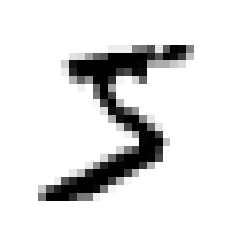

In [4]:
#obtaining first digit
some_digit = X[0]
#making digit larger
some_digit_image = some_digit.reshape(28, 28)

#displaying digit
plt.imshow(some_digit_image, cmap=mpl.cm.binary)
plt.axis("off")
plt.show()

In [5]:
#verifying digit
y[0]

'5'

In [6]:
#casting as integer because they are listed as a string
y = y.astype(np.uint8)

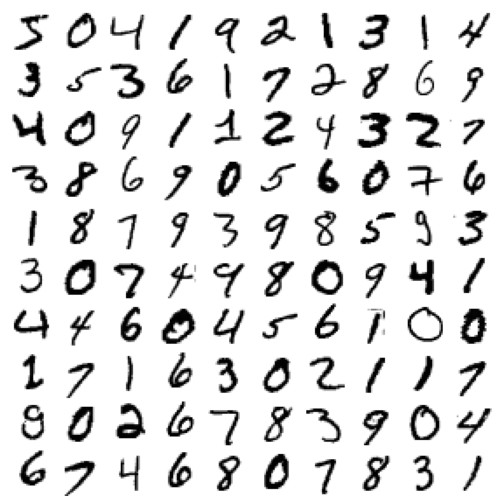

In [7]:
plt.figure(figsize=(9,9))
example_images = X[:100]
functions.plot_digits(example_images, images_per_row=10)
plt.show()

In [8]:
#splitting into train and test data set
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

# Binary Classifier

- We will predict whether or not a number is a 5 or not

## SGD Classifier

In [9]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [10]:
#Creating a SGD Classifier and training it on training set
sgd_clf = SGDClassifier(max_iter=1000, tol=1e-3, random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [11]:
sgd_clf.predict([some_digit])

array([ True])

In [12]:
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

In [13]:
#performing stratified sampling to get a representative ratio of each class
skfolds = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.9669
0.91625
0.96785


- This is a pretty good ratio of correct predictions but let's look at a classifier that classifies every single image in the "not-5" class

In [14]:
class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [15]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

- This has an accuracy over 90% but that's to be expected since there are 90% of numbers that are "not-5"
- We should look at other measures other than accuracy to measure performance

### Confusion Matrix

In [16]:
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [17]:
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

In [18]:
# pretend we reached perfection
y_train_perfect_predictions = y_train_5
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]])

In [19]:
#accuracy of positive predictions
precision_score(y_train_5, y_train_pred)

0.8370879772350012

In [20]:
#true positive rate
recall_score(y_train_5, y_train_pred)

0.6511713705958311

In [21]:
#weighted score of the precision and recall
f1_score(y_train_5, y_train_pred)

0.7325171197343846

- We cannot set the threshold of the decision functino for the f1-score but we do have access to the decision scores that it uses to make predictions. 

### Precision vs Recall

In [22]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

- With a score above zero, the precision scores will be higher than the recall score
- We can check the decision score in another way below

In [23]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

- Let's get the scores off all instances in the trainging set

In [24]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                             method="decision_function")

- Now let's compute the precision and recall scores for all possible thresholds

In [25]:
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

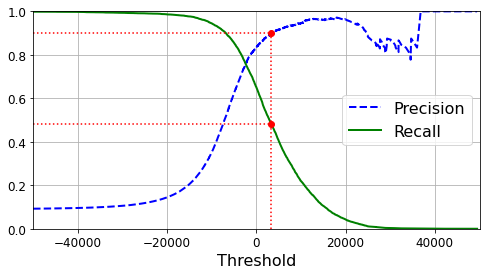

In [26]:
functions.plot_precision_recall_vs_threshold(precisions, recalls, thresholds)

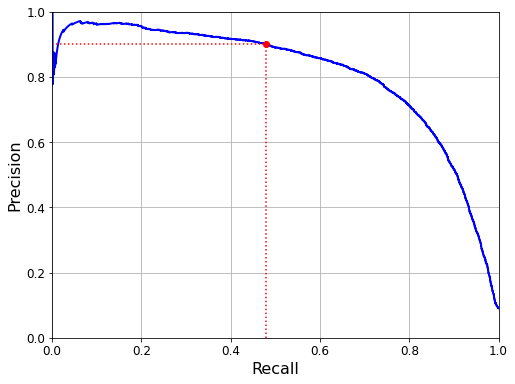

In [27]:
functions.plot_precision_vs_recall(precisions, recalls)

- The precision really starts to fall sharply around 80% recall.
- Sticking to previous examples, let's take a look at 90% precision

In [28]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]
threshold_90_precision

3370.0194991439557

In [29]:
y_train_pred_90 = (y_scores >= threshold_90_precision)

In [30]:
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [31]:
recall_score(y_train_5, y_train_pred_90)

0.4799852425751706

### ROC Curve

In [32]:
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

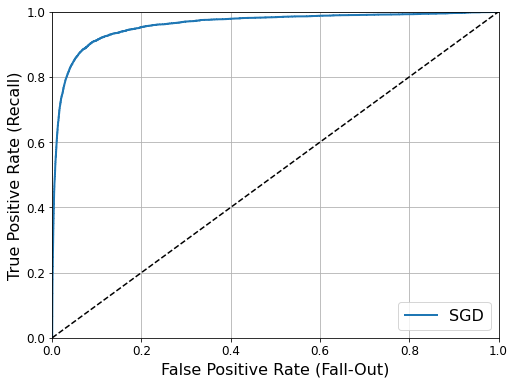

In [33]:
functions.plot_roc_curve(fpr,tpr,'SGD')

## Random Forest Classifier

In [34]:
forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
                                    method="predict_proba")

In [35]:
# score = probability of positive class
y_scores_forest = y_probas_forest[:, 1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5,y_scores_forest)

In [36]:
recall_90_precision = recalls[np.argmax(precisions >= 0.90)]
fpr_90 = fpr[np.argmax(tpr >= recall_90_precision)] 

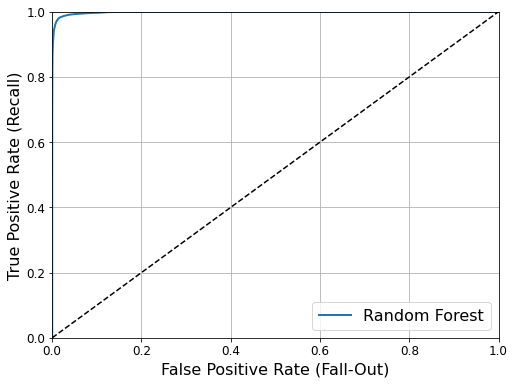

In [37]:
recall_for_forest = tpr_forest[np.argmax(fpr_forest >= fpr_90)]
functions.plot_roc_curve(fpr_forest, tpr_forest, "Random Forest") 

- This performed much better than the SGD Classifier as one can see by looking how close the curve is to the top left corner

# Multiclass Classification

## Support Vector Machine Classifier

In [38]:
#training and predicting on multiple classes
svm_clf = SVC(gamma="auto", random_state=42)
svm_clf.fit(X_train[:1000], y_train[:1000])
svm_clf.predict([some_digit])

array([5], dtype=uint8)

In [39]:
#scores based on the one-versus-one strategy
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores

array([[ 2.81585438,  7.09167958,  3.82972099,  0.79365551,  5.8885703 ,
         9.29718395,  1.79862509,  8.10392157, -0.228207  ,  4.83753243]])

In [40]:
svm_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [41]:
np.argmax(some_digit_scores)

5

- The digit 5 had the highest score

- We can switch to a one-versus-rest strategy by forcing Scikit-Learn to do so

## OneVsRest Classifier

In [42]:
ovr_clf = OneVsRestClassifier(SVC(gamma="auto", random_state=42))
ovr_clf.fit(X_train[:1000], y_train[:1000])
ovr_clf.predict([some_digit])

array([5], dtype=uint8)

In [43]:
len(ovr_clf.estimators_)

10

In [44]:
#Did not have to run OvR or OvO because SGD classifiers can directly classify instances into mutliple classes
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([3], dtype=uint8)

In [45]:
#The decision function method now returns one value per class
sgd_clf.decision_function([some_digit])

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

- The classifier is fairly confident about its prediction because almost all the scores are largely negative except for class 3, which has a score of 1823. 
- We will use cross-validation to evaluate the accuracy

In [46]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.87365, 0.85835, 0.8689 ])

- Next we will scale the inputs with a StandardScaler to increase the accuracy

## Standard Scaling

In [47]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))

In [48]:
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.8983, 0.891 , 0.9018])

In [49]:
#creating a confusion matrix for the scaled data 
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]])

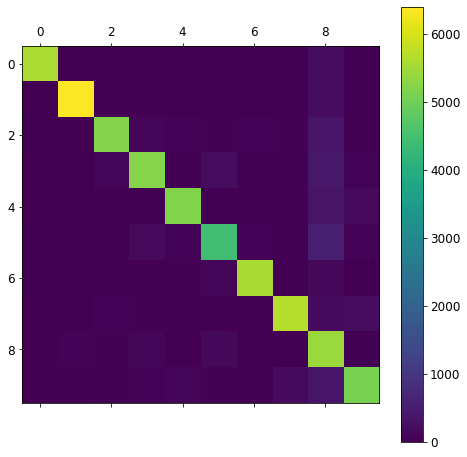

In [50]:
#creating an image for the confusion matrix for easier reading
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
cax = ax.matshow(conf_mx)
fig.colorbar(cax)
plt.show()

- Confusion matrix looks pretty good since most images are on the main diagonal, which means they were classified correctly.
- The 5s look slightly darker than the other digits, which could mean that there are fewer images of 5s in the dataset or that the classifier does not perform as well on 5s as on other digits.
- Let's check both

In [51]:
#comparing error rates
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

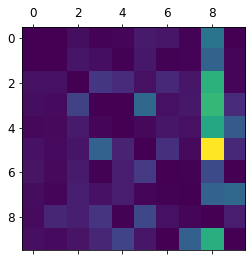

In [52]:
#fill the diagonal with zeros to keep only the errors and the plot result
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx)
plt.show()

- the rows represent actual classes and the columns represnt the predicted value
- the column for class 8 is bright which tells us that many images get misclassified as 8s.
- the row for class 8 is not that bad though, which means that 8s in general get properly classified as 8s.
- it appears that 3s and 5s often get confused in both directions

- Since this is a small dataset, let's analyze individual errors of 3s and 5s

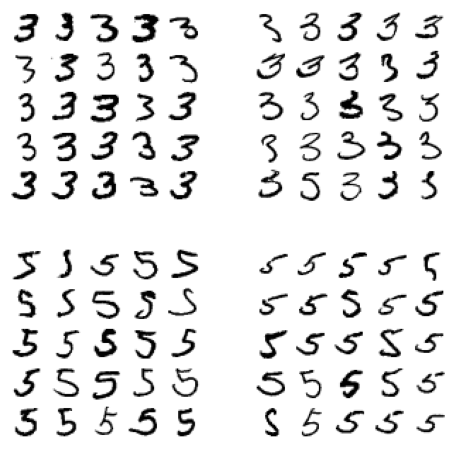

In [53]:
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221); functions.plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); functions.plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); functions.plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); functions.plot_digits(X_bb[:25], images_per_row=5)
plt.show()

- The two 5x5 blocks on the left show digits classified as 3s and the two 5x5 blocks on the right show images classified as 5s. 
- The bottom-left and top-right have numbers so badly written that even a human would have some trouble classifying the numbers but others are clearly obvious that they are wrong.
- This SGDClassifier is quite sensitive to image shifting and the main difference between 3s and 5s is the position of the small line that joins the top line to the bottom arc. 
- A way to reduce the 3/5 confusion would be to preprocess the images to ensure that they are well centered and not too rotated.

# Multilabel Classification

In [64]:
#creating an array containing two target labels, whether a number is 7,8 or 9 and whether or not it is odd
y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

In [65]:
#testing number 5 with the multilabel classification
knn_clf.predict([some_digit])

array([[False,  True]])

In [66]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average="macro")

0.976410265560605

# Multioutput Classification

- Let's start by removing noise from the images

In [67]:
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

- The left image is the noisy input and the right is the clean target image.
- Now let's train the classifier and make it clean the image

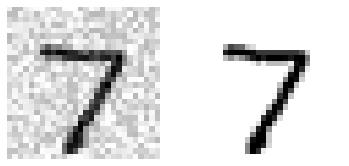

In [68]:
some_index = 0
plt.subplot(121); functions.plot_digit(X_test_mod[some_index])
plt.subplot(122); functions.plot_digit(y_test_mod[some_index])
plt.show()

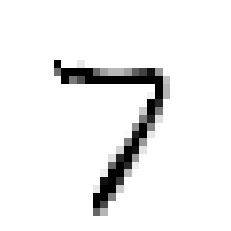

In [69]:
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_index]])
functions.plot_digit(clean_digit)

- Looks close enough to the target :-)

# Grid Search

- We will use GridSearchCV to find good hyperparameter values that will increase accuracy

In [ ]:
param_grid = [{'weights': ["uniform", "distance"], 'n_neighbors': [3, 4, 5]}]

knn_clf = KNeighborsClassifier()
grid_search = GridSearchCV(knn_clf, param_grid, cv=5, verbose=3)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] n_neighbors=3, weights=uniform ..................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ...... n_neighbors=3, weights=uniform, score=0.972, total=10.3min
[CV] n_neighbors=3, weights=uniform ..................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 10.3min remaining:    0.0s


[CV] ...... n_neighbors=3, weights=uniform, score=0.971, total=10.4min
[CV] n_neighbors=3, weights=uniform ..................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed: 20.7min remaining:    0.0s


[CV] ...... n_neighbors=3, weights=uniform, score=0.969, total=10.3min
[CV] n_neighbors=3, weights=uniform ..................................
[CV] ...... n_neighbors=3, weights=uniform, score=0.969, total=10.3min
[CV] n_neighbors=3, weights=uniform ..................................
[CV] ...... n_neighbors=3, weights=uniform, score=0.970, total=10.4min
[CV] n_neighbors=3, weights=distance .................................
[CV] ..... n_neighbors=3, weights=distance, score=0.972, total=10.3min
[CV] n_neighbors=3, weights=distance .................................
[CV] ..... n_neighbors=3, weights=distance, score=0.972, total=10.3min
[CV] n_neighbors=3, weights=distance .................................
[CV] ..... n_neighbors=3, weights=distance, score=0.970, total=17.6min
[CV] n_neighbors=3, weights=distance .................................


In [ ]:
grid_search.best_params_

In [ ]:
grid_search.best_score_

In [ ]:
y_pred = grid_search.predict(X_test)
accuracy_score(y_test, y_pred)

## Data Augmentation

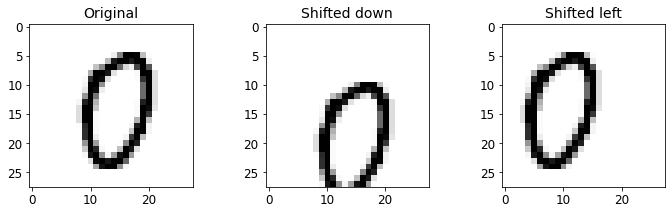

In [60]:
image = X_train[1000]
shifted_image_down = functions.shift_image(image, 0, 5)
shifted_image_left = functions.shift_image(image, -5, 0)

plt.figure(figsize=(12,3))

plt.subplot(131)
plt.title("Original", fontsize=14)
plt.imshow(image.reshape(28, 28), interpolation="nearest", cmap="Greys")

plt.subplot(132)
plt.title("Shifted down", fontsize=14)
plt.imshow(shifted_image_down.reshape(28, 28), interpolation="nearest", cmap="Greys")

plt.subplot(133)
plt.title("Shifted left", fontsize=14)
plt.imshow(shifted_image_left.reshape(28, 28), interpolation="nearest", cmap="Greys")

plt.show()

In [61]:
X_train_augmented = [image for image in X_train]
y_train_augmented = [label for label in y_train]

for dx, dy in ((1, 0), (-1, 0), (0, 1), (0, -1)):
    for image, label in zip(X_train, y_train):
        X_train_augmented.append(shift_image(image, dx, dy))
        y_train_augmented.append(label)

X_train_augmented = np.array(X_train_augmented)
y_train_augmented = np.array(y_train_augmented)

In [62]:
shuffle_idx = np.random.permutation(len(X_train_augmented))
X_train_augmented = X_train_augmented[shuffle_idx]
y_train_augmented = y_train_augmented[shuffle_idx]

In [63]:
knn_clf = KNeighborsClassifier(**grid_search.best_params_)

NameError: name 'grid_search' is not defined

In [ ]:
knn_clf.fit(X_train_augmented, y_train_augmented)

In [ ]:
y_pred = knn_clf.predict(X_test)
accuracy_score(y_test, y_pred)

- By simply augmenting the data, we got a 0.5% accuracy boost